# Cookie cutter

The aim of this notebook is to produce summary statistics for Hazards over NCRA regions, with the flexibility to apply the method to any shapefile region.

Typical statistics include median, mean, min, max, 10th, 90th percentiles

This method has used guidance from [https://github.com/aus-ref-clim-data-nci/shapefiles/blob/master/python_tutorial.ipynb]

<div>
<img src="cookie_cutter.jpg" width="500" title="Cookie cutter"/>
</div>

## Step 1 - access needed packages

In [1]:
# navigate to correct working directory

In [2]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [3]:
# import needed packages
from acs_area_statistics import acs_regional_stats, regions
import xarray as xr

In [4]:
# NCRA regions from acs_area_statistics code
# these are the names of your regions
regions

<regionmask.Regions 'unnamed'>
overlap:  None

Regions:
0  WANorth                          Western Australia North
1  WASouth                          Western Australia South
2      NSW New South Wales and Australian Capital Territory
3      VIC                                         Victoria
4       SA                                  South Australia
5      TAS                                         Tasmania
6       NT                               Northern Territory
7 QLDNorth                                 Queensland North
8 QLDSouth                                 Queensland South
9      AUS                                        Australia

[10 regions]

## Step 2 - Load and prepare data

Open the data you need.

Optional: You may need to perform some selection or summary from your data. 

Optional: You may like to visualise your data t understand it a bit better.


In [5]:
%%time 
# open Hazard data
# this is a slowish part of the code. It is likely to be reused if you're interested in calculating multiple statistics
filename = "/g/data/ia39/ncra/bushfire/fire_climate_classes_AGCD-05i_MM_ssp370_v1-r1-ACS-NRNBC_GWL12.nc"
ds = xr.open_dataset(filename, use_cftime = True,)
ds

CPU times: user 5.24 s, sys: 2.4 s, total: 7.64 s
Wall time: 12.4 s


<xarray.Dataset> Size: 5MB
Dimensions:                   (latitude: 691, longitude: 886, class_code: 66)
Coordinates:
  * latitude                  (latitude) float32 3kB -44.5 -44.45 ... -10.0
  * longitude                 (longitude) float32 4kB 112.0 112.1 ... 156.2
  * class_code                (class_code) int64 528B 0 1 2 3 4 ... 62 63 64 65
Data variables:
    stern_dehoedt_2000_minor  (latitude, longitude) float64 5MB ...
    class short description   (class_code) <U4 1kB ...
    class long description    (class_code) <U35 9kB ...
Attributes:
    data_source:           BARPA ia39
    notebook:              stern_dehoedt_ernst_2000_BARPA.ipynb
    Global_Warming_Level:  1.2
    reference:             Stern, H., De Hoedt, G., & Ernst, J. (2000). Objec...

In [6]:
# optional
# prepare the data, eg maybe you want to select data over smaller range
# here we modify the data coordinate names to read as we expect
ds = ds.rename({"latitude":"lat", "longitude":"lon"})
# fix float rounding errors
ds = ds.assign_coords({"lat":ds.lat.astype("double").round(2), "lon":ds.lon.astype("double").round(2)})
ds

<xarray.Dataset> Size: 5MB
Dimensions:                   (lat: 691, lon: 886, class_code: 66)
Coordinates:
  * class_code                (class_code) int64 528B 0 1 2 3 4 ... 62 63 64 65
  * lat                       (lat) float64 6kB -44.5 -44.45 ... -10.05 -10.0
  * lon                       (lon) float64 7kB 112.0 112.0 ... 156.2 156.2
Data variables:
    stern_dehoedt_2000_minor  (lat, lon) float64 5MB ...
    class short description   (class_code) <U4 1kB ...
    class long description    (class_code) <U35 9kB ...
Attributes:
    data_source:           BARPA ia39
    notebook:              stern_dehoedt_ernst_2000_BARPA.ipynb
    Global_Warming_Level:  1.2
    reference:             Stern, H., De Hoedt, G., & Ernst, J. (2000). Objec...

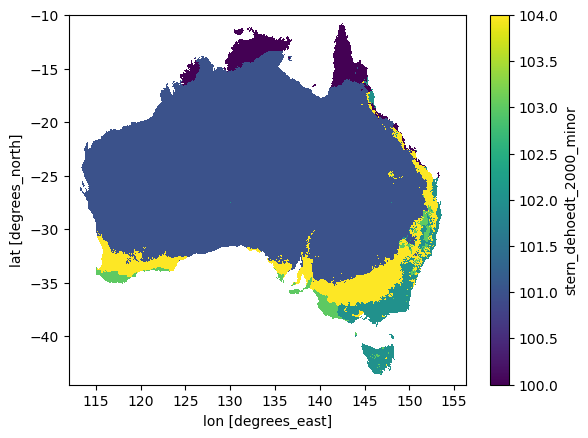

In [7]:
# optional 
# plot if you want to have a look at your data
var = "stern_dehoedt_2000_minor"
ds[var].plot()

## Step 3 - Create your mask

There's a range of ways to calculate your mask:
- **regions.mask_3D(ds)** will create a "mask" array that is ```True``` for all grid cells whose centre point falls within a particular state/territory and ```False``` elsewhere
- **regions.mask_3D_frac_approx(ds)** will calculate the fraction of each grid cell that overlaps with each shape
- **mask_10pct** you may create a mask from the fraction values we need to decide on a minimum overlap threshold. eg ```mask_10pct = regions.mask_3D_frac_approx(ds) >= 0.1```

Fractional masking```regions.mask_3D_frac_approx(ds)``` which will weigh each lat lon grid by the approximate fraction of the area that lay within the shapefile geometery. It  is probably the most accurate, but more expensive than the simple mask_3D.

The masking methods return an xr.DataArray with three dimensions:  **region**, **lat**, and **lon**.

In [8]:
# create your mask
# You can also use a keyword for the function to calculate the mask, but if you're performing multiple calculations, this can be slow.

In [9]:
%%time
# calculate weighted mask this is a very slow part of the code and
# can be reused for any datasets using the same regions and the same lat lon
mask_frac = regions.mask_3D_frac_approx(ds)

CPU times: user 20.8 s, sys: 1.96 s, total: 22.7 s
Wall time: 22.6 s


In [10]:
mask_centre = regions.mask_3D(ds)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/regionmask/core/mask.py:444: UserWarning: Detected overlapping regions. As of v0.11.0 these are correctly taken into account. Note, however, that a different mask is returned than with older versions of regionmask. To suppress this warning, set `overlap=True` (to restore the old, incorrect, behaviour, set `overlap=False`).
  warnings.warn(


## Step 4: Use function
To apply mask calculate a statistic to summarise each region 

In [11]:
# calculate the stats using the acs_region_fractional_stats function
# Find the stats for each region

dims = ("lat", "lon",)
acs_regional_stats(ds=ds,var=var, mask=mask_frac, dims = dims, how = ["min", "median", "max"])


,abbrevs,names,stern_dehoedt_2000_minor_min,stern_dehoedt_2000_minor_median,stern_dehoedt_2000_minor_max
region,,,,,
0,WANorth,Western Australia North,100.0,101.0,101.994189
1,WASouth,Western Australia South,101.0,101.0,104.000000
2,NSW,New South Wales and Australian Capital Territory,101.0,101.0,104.000000
3,VIC,Victoria,101.0,102.0,104.000000
4,SA,South Australia,101.0,101.0,104.000000
5,TAS,Tasmania,102.0,102.0,104.000000
6,NT,Northern Territory,100.0,101.0,101.000000
7,QLDNorth,Queensland North,100.0,101.0,104.000000
8,QLDSouth,Queensland South,100.0,101.0,104.000000


In [12]:
# use with different mask
dims = ("lat", "lon",)
acs_regional_stats(ds=ds,var=var, mask=mask_centre, dims = dims, how = ["min", "median", "max"])


,abbrevs,names,stern_dehoedt_2000_minor_min,stern_dehoedt_2000_minor_median,stern_dehoedt_2000_minor_max
region,,,,,
0,WANorth,Western Australia North,100.0,101.0,101.988278
1,WASouth,Western Australia South,101.0,101.0,103.999999
2,NSW,New South Wales and Australian Capital Territory,101.0,101.0,104.000000
3,VIC,Victoria,101.0,102.0,104.000000
4,SA,South Australia,101.0,101.0,104.000000
5,TAS,Tasmania,102.0,102.0,104.000000
6,NT,Northern Territory,100.0,101.0,101.000000
7,QLDNorth,Queensland North,100.0,101.0,104.000000
8,QLDSouth,Queensland South,100.0,101.0,104.000000
